<a href="https://colab.research.google.com/github/marcvonrohr/machine_learning/blob/main/lab_5/lab_05_text-generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align='center' style='max-width: 1000px' src='https://github.com/HSG-AIML-Teaching/ML2025-Lab/blob/main/lab_5/figures/banner.png?raw=1'>

<img align='right' style='max-width: 200px; height: auto' src='https://github.com/HSG-AIML-Teaching/ML2025-Lab/blob/main/lab_5/figures/hsg_logo.png?raw=1'>

##  Lab 05 - Recurrent Neural Networks - Text Generation

Machine Learning, University of St. Gallen, Spring Term 2025

In this notebook, we will explore the power of recurrent neural networks (RNNs) for generating text. Specifically, we will train a character-level RNN using PyTorch on the Shakespeare's Sonnet dataset. We will implement the RNN from scratch (without using the RNN module from `torch.nn`) and train it in batches to handle variable-length sequences. After training, we will evaluate the model by generating random prompts. Then we will implement an LSTM-based model using the LSTM module from PyTorch to see how it can improve the quality of the output. Below you can see the illustration of the models we aim to implement:

<img align='center' style='max-width: 600px' src='https://github.com/HSG-AIML-Teaching/ML2025-Lab/blob/main/lab_5/animations/objective.gif?raw=1'>

Lab Objectives:
- Learn how to create a PyTorch dataset for sequence-based training of textual data.
- Implement an RNN from scratch using PyTorch that predicts the next character given a context.
- Generate random texts by prompting the model.
- Improve upon the RNN model and implement an LSTM-based model.


We will see how the model can generate text that resembles Shakespeare's sonnets.


# 1. Dataset

The dataset we will be using for this notebook is the collection of 154 sonnets by William Shakespeare. The sonnets were published in 1609 and have since become some of the most famous and influential poems in English literature.

You can download the dataset from the Project Gutenberg website which a repository of free ebooks that are in the public domain. The sonnets are available for free download and can be used for any purpose without restriction. However, it's worth noting that some adaptations of the sonnets or translations may be protected by copyright, so it's always important to double-check the legal status of any text you plan to use for your project.

For more information, please refer to this link: https://www.gutenberg.org/ebooks/1041


The preprocessed version of the dataset can be downloaded from the link below:

Download link: https://raw.githubusercontent.com/ccc-frankfurt/Practical_ML_SS21/master/week06/sonnets.txt

Before everything, let's import some libraries that we will use for data processing, training and evaluation:

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np


### Loading the dataset in PyTorch

The first step is to understand how the data looks and how to prepare it for training. Since we cannot directly work with characters in neural networks, we need to map each character in the dataset to a unique identifier:

<img align='center' style='max-width: 800px' src='https://github.com/HSG-AIML-Teaching/ML2025-Lab/blob/main/lab_5/animations/char_mapping.gif?raw=1'>

Since we want to train the model to predict the next character based on the seen context, the inputs and outputs for model traing are constructed by randomly selecting sub-strings from the dataset to construct each pair. The input to the model will be the substring itself and the target will the substring shifted to the left by one character:

<img align='center' style='max-width: 800px' src='https://github.com/HSG-AIML-Teaching/ML2025-Lab/blob/main/lab_5/figures/batch_example.png?raw=1'>

To create a PyTorch dataset for our data, we need to define a class that inherits from the class `Dataset` in `torch.utils.data`. In the constructor of the class, we load the text data and prepare the mappings.

In [51]:
class SonnetDataset(Dataset):
    def __init__(self, ds_path, seq_length):
        # Read text file
        with open(ds_path, 'r') as f:
            text = f.read()

        # Create set of all possible unique characters. Addtionally add the character `#`
        # as an indicator of the end of the sentence.
        self.chars = ['#'] + sorted(list(set(text)))

        # Char-to-ID and ID-to-Char mappers
        char_to_int = {c: i for i, c in enumerate(self.chars)}
        int_to_char = {i: c for i, c in enumerate(self.chars)}

        self.text = text
        self.char_to_int = char_to_int
        self.int_to_char = int_to_char
        self.seq_length = seq_length

    def __len__(self):
        # Return the total number of setences that the dataset includes
        return len(self.text) - self.seq_length

    def __getitem__(self, index):
        # Return a random substring with its correponding target.
        sequence = self.text[index:index + self.seq_length + 1]
        target = self.text[index + 1:index + self.seq_length + 1] + '#'

        return (torch.tensor([self.char_to_int[c] for c in sequence], dtype=torch.long), torch.tensor([self.char_to_int[c] for c in target], dtype=torch.long))

Now, we create an instance of the dataset which will be used for training both models.

In [52]:
!wget https://raw.githubusercontent.com/ccc-frankfurt/Practical_ML_SS21/master/week06/sonnets.txt
dataset = SonnetDataset(ds_path="./sonnets.txt", seq_length=100)

--2025-03-24 14:11:32--  https://raw.githubusercontent.com/ccc-frankfurt/Practical_ML_SS21/master/week06/sonnets.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94081 (92K) [text/plain]
Saving to: ‘sonnets.txt.3’

sonnets.txt.3       100%[===================>]  91.88K  --.-KB/s    in 0.01s   

2025-03-24 14:11:32 (6.38 MB/s) - ‘sonnets.txt.3’ saved [94081/94081]



In [53]:
dataset = SonnetDataset(ds_path="/content/sonnets.txt", seq_length=100)

In [54]:
dataset[0]

(tensor([18, 53, 50, 48,  2, 41, 36, 44, 53, 40, 54, 55,  2, 38, 53, 40, 36, 55,
         56, 53, 40, 54,  2, 58, 40,  2, 39, 40, 54, 44, 53, 40,  2, 44, 49, 38,
         53, 40, 36, 54, 40,  7,  1, 31, 43, 36, 55,  2, 55, 43, 40, 53, 40, 37,
         60,  2, 37, 40, 36, 56, 55, 60,  4, 54,  2, 53, 50, 54, 40,  2, 48, 44,
         42, 43, 55,  2, 49, 40, 57, 40, 53,  2, 39, 44, 40,  7,  1, 14, 56, 55,
          2, 36, 54,  2, 55, 43, 40,  2, 53, 44, 51]),
 tensor([53, 50, 48,  2, 41, 36, 44, 53, 40, 54, 55,  2, 38, 53, 40, 36, 55, 56,
         53, 40, 54,  2, 58, 40,  2, 39, 40, 54, 44, 53, 40,  2, 44, 49, 38, 53,
         40, 36, 54, 40,  7,  1, 31, 43, 36, 55,  2, 55, 43, 40, 53, 40, 37, 60,
          2, 37, 40, 36, 56, 55, 60,  4, 54,  2, 53, 50, 54, 40,  2, 48, 44, 42,
         43, 55,  2, 49, 40, 57, 40, 53,  2, 39, 44, 40,  7,  1, 14, 56, 55,  2,
         36, 54,  2, 55, 43, 40,  2, 53, 44, 51,  0]))

# 2. Vanilla RNNs

<img align='center' style='max-width: 800px' src='https://github.com/HSG-AIML-Teaching/ML2025-Lab/blob/main/lab_5/animations/rnn_generation.gif?raw=1'>

### 2.1 RNN Cell

The core component of an RNN model is an RNN cell that requires two inputs. One input is the current character in the text and other input is the hidden state of the model. The hidden state is also known as the memory of the model that carries useful information along the text which enables prediction based on a given context. In the figure below, we can see that some mathematical operation is performed on the inputs to make prediction for the output at step t and update the hidden vector based on the current input:

<img align='center' style='max-width: 400px' src='https://github.com/HSG-AIML-Teaching/ML2025-Lab/blob/main/lab_5/figures/rnn_cell.png?raw=1'>

Let's first define the RNN cell:

In [55]:
# Define the RNN Cell
class RNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNNCell, self).__init__()
        # Linear transformation for the input
        self.input_hidden = nn.Linear(input_size, hidden_size)
        # Linea transformation for the hidden state
        self.hidden_hidden = nn.Linear(hidden_size, hidden_size)
        # Activation and dropout
        self.activation = nn.Tanh()
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x, hidden):
        # Tranform input
        x = self.input_hidden(x)
        # Transform hidden state
        hidden_t = self.hidden_hidden(hidden)
        # Add the transformed hidden state to the transformed input to
        # form the new hidden state
        new_hidden = self.activation(x + hidden_t)
        new_hidden = self.dropout(new_hidden)

        return new_hidden

In [56]:
rnn_cell = RNNCell(128, 128)

x = torch.randn(5, 128)
h = torch.randn(5, 128)

rnn_cell(x, h).shape

torch.Size([5, 128])

### 2.2 RNN Model

One last point for the implementation of the RNN model is the conversion of text character IDs to vectors. We cannot directly feed integers to a neural network, therefore we have to common options for converting integers to vectors.

1 - One-hot encoded vectors

2 - Using embedding look-up tables

For this tutorial, we go for the second option. To do so we use the `nn.Embedding` module from PyTorch that initializes a list of trainable tensors, one per character in our case. Every time we give it a list of character IDs, it selects the correponding tensors from the table and returns them. We finally then use those tensors as inputs to the RNN cell.

In [57]:
# Define the RNN model
class SimpleRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        # Character embedding
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=hidden_size)
        # RNN cell
        self.rnn_cell = RNNCell(hidden_size, hidden_size)
        # Classification layer
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden):
        # Convert input to vector embeddings using a lookup table
        x_emb = self.embedding(x)
        # Forward the input and hidden state to the RNN cell
        new_hidden = self.rnn_cell(x_emb, hidden)
        # Make prediction using the new hidden sate
        output = self.fc(new_hidden)

        return output, new_hidden

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)


In [58]:
model = SimpleRNN(vocab_size=len(dataset.chars), hidden_size=128)


### 2.3 Text Generation

Before training the model, we want to test it with text generation to check how the generated texts look. We need to implement a function that takes as input the model, the character <-> char-ID convertors and the prompt.

In [59]:
# Generate random text
def generate_text(model, char_to_int, int_to_char, prompt, device):
    # Set model to eval mode
    model.eval()

    # Initialize the hidden state of the RNN cell with batch-size = 1
    hidden = model.init_hidden(1)
    if type(hidden) == tuple:
        hidden = (hidden[0].squeeze(1).to(device), hidden[1].squeeze(0).to(device))
    else:
        hidden = hidden.to(device)

    # Convert the prompt characters to character IDs
    input_sequence = torch.tensor([char_to_int[c] for c in prompt], dtype=torch.long).unsqueeze(0).to(device)

    # Store the generated text over time as a string
    generated_text = prompt

    # No gradient mode during inference
    with torch.no_grad():
        # First feed all prompt characters to the model to the the final output and hidden state
        for i in range(len(input_sequence[0])):
            output, hidden = model(input_sequence[0][i].unsqueeze(0), hidden)

        next_input = torch.argmax(output, dim=1)

        # Generate text until the model outputs character #
        while True:
            # At each step, predict the next character given the current input and
            # the hidden state from previous step
            output, hidden = model(next_input, hidden)
            # Sample from the probability distribution produced by the model at step t
            probabilities = nn.functional.softmax(output, dim=1)
            predicted_char = torch.multinomial(probabilities[0], 1)

            # !!!!! Another option would be greedy character selection
            # predicted_char = torch.argmax(probabilities, dim=1)

            # Conver the character ID to string and add it to `generated_text`
            if int_to_char[predicted_char[0].item()] == "#":
                break
            generated_text += int_to_char[predicted_char[0].item()]
            next_input = predicted_char

    return generated_text

In [60]:
prompt = "St. Gallen, where the "
generate_text(model, dataset.char_to_int, dataset.int_to_char, prompt, device=torch.device("cuda"))

"St. Gallen, where the AVe)AD(kJ'IIYzqRf"

### 2.4 Training

We saw that the randomly initialized model generates meaningless random text. Let's train the model on the Shakespeare's sonnets dataset. Since we need to train the model of sequence of inputs, the computational grpah of the model needs to be replicated over all steps of the character sequence generation process. At the end of the sentence, the losses from all steps are summed together and backpropagation is applied to compute the gradients. In this case we are doing `Backpropgation Through Time` (BPTT). In the animation below, we can see how the forward and backward propagation is performed for sequential data generation:

<img align='center' style='max-width: 900px' src='https://github.com/HSG-AIML-Teaching/ML2025-Lab/blob/main/lab_5/animations/rnn_training.gif?raw=1'>

Similar to before, we need to define a function that train the model for a number of epochs. The only part that is different is how we feed the data to the model. One way to input sequential data is to iterate through the batch sequences step by step, forward the characters at step t and compute the loss for that step. After going throught eh sequence, we compute the average loss and backpropagate. PyTorch takes cares of the BPTT part :)

In [61]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    dataloader_progress = tqdm.tqdm(dataloader)
    iter_losses = []
    # Iterate over all dataset sentences
    for i, (inputs, targets) in enumerate(dataloader_progress):
        # Size of input and targetsa re B x L x D
        # B -> batch size, L -> sequence length, D -> vocabulary size
        inputs, targets = inputs.to(device), targets.to(device)
        batch_size = inputs.shape[0]
        len_sequence = inputs.shape[1]
        # Initialize the hidden state with zeros before going through the sequence
        hidden = model.init_hidden(batch_size).to(device)
        optimizer.zero_grad()
        loss = 0
        # Make prediction for each character and compute the loss for each step
        for t in range(len_sequence):
            output, hidden = model(inputs[:, t], hidden)
            loss += criterion(output, targets[:, t])
        # Compute average loss over all steps
        loss = loss / len_sequence
        # Backpropagate and optimizer step
        loss.backward()
        optimizer.step()
        dataloader_progress.set_description(f"Loss: {loss.item():0.5f}")
        # Iteration losss
        iter_losses.append(loss.item())

    return np.mean(iter_losses)

In [63]:
device = torch.device("cuda")

# Hyperparameters
hidden_size = 256
seq_length = 100
batch_size = 64
num_epochs = 3
learning_rate = 0.001

model = SimpleRNN(vocab_size=len(dataset.chars), hidden_size=hidden_size)
model.to(device)
model.train()

# Create dataset and dataloader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
epoch_losses = []
for epoch in range(num_epochs):
    epoch_loss = train(model, dataloader, criterion, optimizer, device)
    print(f'Epoch {epoch + 1}/{num_epochs} completed')
    epoch_losses.append(epoch_loss)

Loss: 1.94130: 100%|██████████| 1468/1468 [02:17<00:00, 10.65it/s]


Epoch 1/3 completed


Loss: 1.93215: 100%|██████████| 1468/1468 [02:15<00:00, 10.86it/s]


Epoch 2/3 completed


Loss: 1.91147: 100%|██████████| 1468/1468 [02:11<00:00, 11.15it/s]

Epoch 3/3 completed


In [70]:
torch.save(model, "ckpt_rnn.pt")

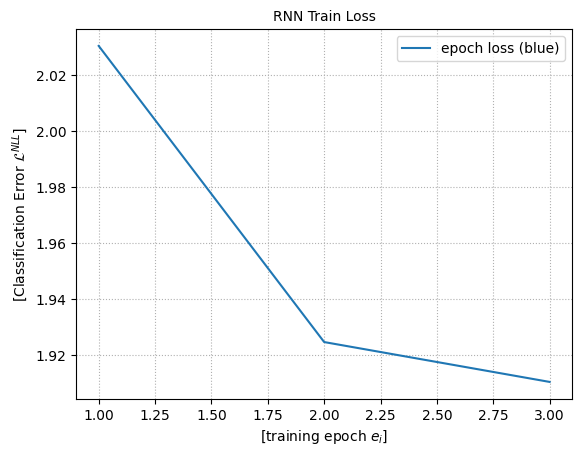

In [71]:
# Prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add grid
ax.grid(linestyle='dotted')

# Plot the training epochs vs. the epochs' classification error
ax.plot(np.array(range(1, len(epoch_losses)+1)), epoch_losses, label='epoch loss (blue)')

# Plot details
ax.set_xlabel("[training epoch $e_i$]", fontsize=10)
ax.set_ylabel("[Classification Error $\mathcal{L}^{NLL}$]", fontsize=10)
plt.legend(loc="upper right", numpoints=1, fancybox=True)
plt.title('RNN Train Loss', fontsize=10);

### 2.5 Testing

Finally, it's time for testing the model.

In [72]:
prompt = "St. Gallen, where the "
model.to("cuda")
generate_text(model, dataset.char_to_int, dataset.int_to_char, prompt, device=torch.device("cuda"))

"St. Gallen, where the harve mary brimed,\nAnd to perchaised can noth your remy with payed aif the looks\nFor breaving bagdost if lesvoned the scy to glace heoming;\nWhere sworth olf thy lied with conthy sinct of thou in thy fast agher,\nThy seld the lare\nThoughty?\nNis why world Tath hyis you then;\nThat think, purvite, bold make's weng"

# 3. LSTMs

We saw that RNNs can suffer from the vanishing gradient problem, which means that the gradients used to update the parameters of the network can become very small over time, leading to slow convergence and poor performance. Now let's see how we can solve that issue.


### 3.1 LSTM Cell


LSTMs are designed to overcome the vanishing gradient problem by using a more sophisticated architecture that incorporates a memory cell and multiple gating mechanisms. The memory cell is responsible for storing information over long periods of time, while the gating mechanisms control the flow of information into and out of the cell. This allows LSTMs to selectively forget or remember information, which makes them more effective in capturing long-term dependencies in sequential data. Below you can see the architecture of an LSTM cell:

<img align='center' style='max-width: 700px' src='https://github.com/HSG-AIML-Teaching/ML2025-Lab/blob/main/lab_5/figures/lstmcell.png?raw=1'>

Everything remails similar to the RNN implementation, but here we want to use the PyTorch's LSTM module from `nn.LSTM` instead of implementing it from scatch. Let's first create an instance of an LSTM cell and see how we can interact with it.

In [73]:
# Create an instance of nn.LSTM. It's import to set batch_first=True if the data tensor shape is B x L x D
lstm = nn.LSTM(10, 30, batch_first=True)
# Initialize input, and the first hidden and context vectors
inp = torch.randn(5, 3, 10)
h0 = torch.randn(1, 5, 30)
c0 = torch.randn(1, 5, 30)
# Forward
output, (hn, cn) = lstm(inp, (h0, c0))

### 3.2 LSTM Model

Now, let's implement the LSTM model. We use an `nn.Embedding` module to conver character IDs to learnable tensors.

In [74]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, hidden_size, dropout=0.5):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        # Character embedding module
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        # PyTorch's LSTM module
        self.lstm = nn.LSTM(hidden_size, hidden_size, dropout=dropout, batch_first=True)
        # Classification layer
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden):
        x = self.embedding(x)
        output, hidden = self.lstm(x, hidden)
        output = self.fc(output)
        return output, hidden

    def init_hidden(self, batch_size):
        hidden = (torch.zeros(1, batch_size, self.hidden_size),
                  torch.zeros(1, batch_size, self.hidden_size))
        return hidden


### 3.3 Training

And the final step is to train the LSTM model:

In [75]:
device = torch.device("cuda")

dataset = SonnetDataset(ds_path="/content/sonnets.txt", seq_length=100)

# Hyperparameters
hidden_size = 512
seq_length = 200
batch_size = 128
num_epochs = 5
learning_rate = 0.001

# Create dataset and dataloader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Instantiate the model and the loss function
model = LSTMModel(vocab_size=len(dataset.chars), hidden_size=hidden_size,)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
epoch_losses = []
for epoch in range(num_epochs):
    model.train()
    dataloader_progress = tqdm.tqdm(dataloader)
    iter_losses = []
    for i, (inputs, targets) in enumerate(dataloader_progress):
        inputs, targets = inputs.to(device), targets.to(device)
        batch_size = inputs.size(0)

        # Initialize the hidden state
        hidden = model.init_hidden(batch_size)
        hidden = (hidden[0].to(device), hidden[1].to(device))

        optimizer.zero_grad()
        loss = 0

        # Forward pass
        output, hidden = model(inputs, hidden)

        # To enable a faster computation of the loss at each step, we linearize
        # predictions and targets for all steps and compute the loss for all steps together
        loss = criterion(output.view(-1, output.shape[2]), targets.view(-1))

        # Backpropagation and optimizer step
        loss.backward()
        optimizer.step()

        iter_losses.append(loss.item())
        dataloader_progress.set_description(f"Loss: {loss.item():0.5f}")
    print(f'Epoch {epoch + 1}/{num_epochs} completed')
    epoch_losses.append(np.mean(iter_losses))


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
Loss: 0.68471: 100%|██████████| 734/734 [00:41<00:00, 17.61it/s]


Epoch 1/5 completed


Loss: 0.28451: 100%|██████████| 734/734 [00:43<00:00, 17.01it/s]


Epoch 2/5 completed


Loss: 0.21524: 100%|██████████| 734/734 [00:44<00:00, 16.48it/s]


Epoch 3/5 completed


Loss: 0.19553: 100%|██████████| 734/734 [00:44<00:00, 16.45it/s]


Epoch 4/5 completed


Loss: 0.19124: 100%|██████████| 734/734 [00:44<00:00, 16.45it/s]

Epoch 5/5 completed


In [76]:
torch.save(model, "ckpt_lstm.pt")

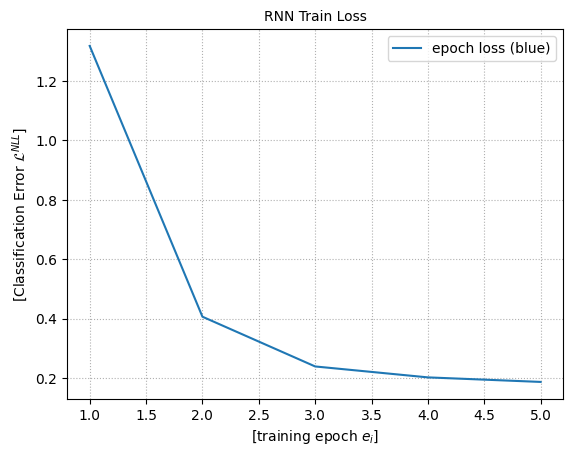

In [77]:
# Prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add grid
ax.grid(linestyle='dotted')

# Plot the training epochs vs. the epochs' classification error
ax.plot(np.array(range(1, len(epoch_losses)+1)), epoch_losses, label='epoch loss (blue)')

# Plot details
ax.set_xlabel("[training epoch $e_i$]", fontsize=10)
ax.set_ylabel("[Classification Error $\mathcal{L}^{NLL}$]", fontsize=10)
plt.legend(loc="upper right", numpoints=1, fancybox=True)
plt.title('RNN Train Loss', fontsize=10);

### 3.4 Testing

In [78]:

prompt = "Saint Gallen, where the "
generate_text(model, dataset.char_to_int, dataset.int_to_char, prompt, device=device)

'Saint Gallen, where the umb on hught of Sir,\nThat so my patent all dressing old words bri'

In [79]:
prompt = " "
generate_text(model, dataset.char_to_int, dataset.int_to_char, prompt, device=device)

' hee.\n\nWhen forty winters shall be a salve war not a perfect best,\nAnd pater'